In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, model_selection, preprocessing, pipeline, impute, feature_selection
from sklearn.experimental import enable_iterative_imputer
from itertools import chain, combinations, product
import math
import time

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)


import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

%matplotlib inline
from pyAgrum.lib.bn2roc import showROC
from pyAgrum.lib.bn2roc import showPR
from pyAgrum.lib.bn2roc import showROC_PR

import networkx as nx
import graphviz

In [2]:
data = pd.read_csv("insurance.csv")
data

,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear,ThisCarDam,RuggedAuto,Accident,MakeModel,DrivQuality,...,HomeBase,AntiTheft,PropCost,OtherCarCost,OtherCar,MedCost,Cushioning,Airbag,ILiCost,DrivHist
0,False,Adult,Prole,Adventurous,Older,Moderate,EggShell,Mild,Economy,Poor,...,City,False,TenThou,Thousand,True,Thousand,Poor,False,Thousand,Many
1,False,Senior,Prole,Cautious,Current,None,Football,None,Economy,Normal,...,City,True,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero
2,False,Senior,UpperMiddle,Psychopath,Current,None,Football,None,FamilySedan,Excellent,...,City,False,Thousand,Thousand,False,Thousand,Good,True,Thousand,One
3,False,Adolescent,Middle,Normal,Older,None,EggShell,None,Economy,Normal,...,Suburb,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Zero
4,False,Adolescent,Prole,Normal,Older,Moderate,Football,Moderate,Economy,Poor,...,City,False,TenThou,Thousand,False,Thousand,Fair,False,Thousand,Many
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,Adult,Prole,Adventurous,Older,Mild,Football,Mild,Economy,Poor,...,City,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Many
19996,False,Adult,Middle,Normal,Older,None,Tank,None,FamilySedan,Normal,...,Suburb,False,Thousand,Thousand,True,Thousand,Good,False,Thousand,Zero
19997,False,Senior,UpperMiddle,Normal,Current,None,Football,None,Luxury,Excellent,...,Secure,True,TenThou,Thousand,False,Thousand,Excellent,True,Thousand,Zero
19998,False,Adult,Middle,Normal,Older,None,Football,None,FamilySedan,Excellent,...,Suburb,False,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero


In [3]:
#X = data[data.columns.drop(["RiskAversion", "Accident"])]
#y = data[["RiskAversion", "Accident"]]

X = data[data.columns.drop("Accident")]
y = data["Accident"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [4]:
app = X_train.copy()
app["Accident"] = y_train

learner=gum.BNLearner(app)

bn = learner.learnBN()

bn=learner.useGreedyHillClimbing().useScoreK2().learnBN()


In [5]:
gnb.flow.add(gnb.getBN(bn,size="20"))
gnb.flow.display()

In [6]:
acc = 0
domain = sorted(np.unique(y_train.to_numpy()))
for i in X_test.index :
    ie=gum.LazyPropagation(bn)
    ie.addTarget("Accident")
    instance = X_test.loc[i]
    for j in X_test.columns :
        ie.addEvidence(j,str(instance[j]))
    ie.makeInference()
    post = ie.posterior("Accident")
    #print(post)
    #print(y_test.loc[i])
    acc = acc + post[domain.index(y_test.loc[i])]
print(acc / len(X_test.index))

0.9259260906261275


In [48]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))

True

In [49]:
bn.nodeset(["OtherCarCost"])

<Swig Object of type 'gum::NodeSet *' at 0x7f6164831d50>

In [ ]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.addEvidence("RiskAversion","Psychopath")
print(ie.posterior(bn.idFromName("Accident")))


In [ ]:
ie=gum.LazyPropagation(bn)
#ie.makeInference()
ie.addEvidence("RiskAversion","Cautious")
ie.addTarget("Accident")
print(ie.posterior("Accident"))

In [ ]:
l = np.unique(y_train.to_numpy())
print(sorted(l))

In [ ]:
import bnlearn as bnl

In [ ]:
model = bnl.structure_learning.fit(data)
model = bnl.parameter_learning.fit(model, data)

In [ ]:
query = bnl.inference.fit(model, variables=['Accident'], evidence={'RiskAversion':"Psychopath"})

In [ ]:
for i in range(0,4):
    print(ie.posterior(bn.idFromName("Accident"))[i])

In [ ]:
le_X = preprocessing.OrdinalEncoder()
le_y = preprocessing.LabelEncoder()

X_train_en = le_X.fit_transform(X_train)
y_train_en = le_y.fit_transform(y_train)

In [ ]:
clf = svm.SVC()
clf.fit(X_train_en, y_train_en)

In [ ]:
clf.predict(le_X.transform(X_test))

In [ ]:
# train an imputer 
imp = impute.SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
#imp = impute.IterativeImputer(missing_values=np.nan, initial_strategy= "most_frequent")
imp.fit(X_train)

In [ ]:
prueba = X_test.head(1).to_numpy()
prueba[0][10:26] = np.nan
imp.transform(prueba)

In [ ]:
X_test.iloc[[1]]

In [ ]:
X_observed = X.columns[0:20]
X_unobserved = [x for x in X if x not in X_observed]

In [ ]:
def powerset(iterable):
    s = list(iterable)
    tmp = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    return tmp

In [ ]:
S = powerset(X_unobserved)
S.pop(0)

In [ ]:
S[10][1]

In [ ]:
def omega(variable, data) :
    return list(data[variable].unique())

In [ ]:
omega("Age",X)

In [ ]:
# OPCIONES PARA PREDICT
# Estimar con los datos la clase más probable
# Estimar con los datos la missing data y utilizar el algoritmo
clf.predict(le_X.transform(X_test.head(1).to_numpy()))

In [ ]:
prueba = X_test.head(1).to_numpy()

In [ ]:
prueba[0][10:26] = np.nan

#prueba.iloc[0,20:26] = np.nan

In [ ]:
clf.predict(le_X.transform(X_test.head(1)))

In [ ]:
X_observed

In [ ]:
def reduce_dataset(instance, X,y) :
    columns = X.columns
    for i,value in enumerate(instance) :
        if isinstance(value, str) or not math.isnan(value) :
            X = X[X[columns[i]] == value]
            X = X.drop(columns[i], axis=1)
    y = y[[j for j in y.index if j in X.index]]
    return X,y

In [ ]:
X['Age'] == "Adult"

In [ ]:
X_test.head(1).to_numpy()

In [ ]:
reduced = reduce_dataset(prueba[0], X)

In [10]:
bn_pr.names()

{'DrivHist', 'DrivingSkill', 'RiskAversion'}

In [8]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))
bn_pr = prune_network(bn, ["DrivingSkill", "RiskAversion"], ["DrivHist"])
#bn_pr.names()

swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python dete

In [7]:
def prune_network(bn, ev_vars, hyp_vars, supp_vars = None) :
    #IMPORTANT: Hard copy of the bn
    bn_pr = gum.BayesNet(bn)
    # Find supplementary nodes of a network if not given
    
    if supp_vars is None :
        supp_vars = []
        for i in bn_pr.names() :
            if not i in ev_vars and not i in hyp_vars :
                supp_vars.append(i)
    # Delete from the network the nodes that are conditionally independent from the hypothesis variables (target) given the evidence
    dsep_nodes = []
    for i in supp_vars :
        if bn_pr.dag().dSeparation(bn_pr.nodeset([i]),bn_pr.nodeset(hyp_vars),bn_pr.nodeset(ev_vars)):
            dsep_nodes.append(i)
            bn_pr.erase(i)
    return bn_pr, dsep_nodes

def predict_wrapper(instance, hyp_vars) :
    ie=gum.LazyPropagation(bn)
    ie.addTarget(hyp_vars)
    for i,value in enumerate(instance) :
        if isinstance(value, str) or not math.isnan(value) :
            ie.addEvidence(columns[i], )
            #ie.
            unobserved_vars.append(columns[i])
    
def omega(variables, data) :
    domains = []
    for variable in variables :
        domains.append(sorted(data[variable].unique()))
    return [p for p in product(*domains)]
    

def prepare_mapi(instances, set_R, data) :
     #Type checking
    if isinstance(instances, pd.core.frame.DataFrame) :
        instances = instances.to_numpy()
    #Array for each instance
    evidences = []
    # For each instance:
    for instance in instances :
        # Check which are the supplementary (missing) variables
        columns = data.columns
        evidence = dict()
        for i,value in enumerate(instance) :
            if isinstance(value, str) or not math.isnan(value) :
                evidence[columns[i]] = value
        evidences.append(evidence)
    return evidences
    

# True if R is relevant/MAP-dependent
# False if R is irrelevant/MAP-independent
def map_independence(instances, set_R, data, bn, hyp_vars) : 
    #Type checking
    if isinstance(instances, pd.core.frame.DataFrame) :
        instances = instances.to_numpy()
    #Array for each instance
    out_array = []
    # For each instance:
    for instance in instances :
        # Check which are the supplementary (missing) variables
        columns = data.columns
        supp_vars = []
        for i,value in enumerate(instance) :
            if not isinstance(value, str) and math.isnan(value) :
                supp_vars.append(columns[i])
        # Check if R in unobserved
        #print(supp_vars)
        for R in set_R :
            if R not in supp_vars :
                print("Error")
                return
        # Impute and predict the instance
        complete_instance = imp.transform([instance])
        y = clf.predict(le_X.transform(complete_instance))
        # Obtain domain of R
        omega_R = omega(set_R, data)
        # For each value assignment r in omega(R)
        out_array.append(False)
        for value_assignment_r in omega_R :
            # Fill in values
            instance_alt = instance.copy()
            for i,value in enumerate(value_assignment_r) :
                instance_alt[list(data.columns).index(set_R[i])] = value
            #print(instance)
            #print(instance_alt)
            # Imputar y predecir 
            complete_instance_alt = imp.transform([instance_alt])
            y_alt = clf.predict(le_X.transform(complete_instance_alt))
            # Comparar con prediccion de instance
            #print(y, " == ", y_alt)
            if y != y_alt :
                out_array.pop()
                out_array.append(True)
                break
    return out_array

In [ ]:
np.nan == np.nan

In [ ]:
out = check_r(prueba, X_train.columns[15:20], X_train)
out

In [ ]:
for i in range(10,23) :
    print(list(range(i,i+3)),check_r(prueba, X_train.columns[i:i+3], X_train))

In [ ]:
def check_every_r(instances, data) :
    #Type checking
    if isinstance(instances, pd.core.frame.DataFrame) :
        instances = instances.to_numpy()
    #Array for each instance
    out_array = []
    # For each instance:
    for instance in instances :
        # Check which are the missing variables
        columns = data.columns
        unobserved_vars = []
        for i,value in enumerate(instance) :
            if not isinstance(value, str) and math.isnan(value) :
                unobserved_vars.append(columns[i])
        S = powerset(unobserved_vars)
        S.pop(0)
        relevant_sets = []
        irrelevant_sets = []
        for i in S :
            if check_r([instance], list(i), data)[0] :
                relevant_sets.append(i)
            else :
                irrelevant_sets.append(i)
        return relevant_sets, irrelevant_sets

In [ ]:
def check_every_r_prune(instances, data) :
    #Type checking
    if isinstance(instances, pd.core.frame.DataFrame) :
        instances = instances.to_numpy()
    #Array for each instance
    out_array = []
    # For each instance:
    for instance in instances :
        # Check which are the missing variables
        columns = data.columns
        unobserved_vars = []
        for i,value in enumerate(instance) :
            if not isinstance(value, str) and math.isnan(value) :
                unobserved_vars.append(columns[i])
        S = powerset(unobserved_vars)
        S.pop(0)
        # Divide by length
        S_split = []
        size = 0
        for i in S :
            if len(i) != size:
                size = size + 1
                S_split.append([])
            S_split[-1].append(i)
        relevant_sets = []
        irrelevant_sets = []
        for i in range(0,len(S_split)) :
            for j in S_split[i] :
                # If relevant
                if check_r([instance], list(j), data)[0] :
                    relevant_sets.append(j)
                    # Apply prune
                    for k in range(i+1,len(S_split)) :
                        tmp = []
                        for l in S_split[k] :
                            if set(j).issubset(set(l)) :
                                relevant_sets.append(l)
                            else :
                                tmp.append(l)
                        S_split[k] = tmp
                # If irrelevant
                else :
                    irrelevant_sets.append(j)
        return relevant_sets, irrelevant_sets

In [ ]:
prueba = X_test.head(1).to_numpy()
prueba[0][0:10] = np.nan
t0 = time.time()
relevant_sets, irrelevant_sets = check_every_r(prueba, X_train)
tf = time.time()
print("Brute force: ",tf-t0)

In [ ]:
t0 = time.time()
relevant_sets_p, irrelevant_sets_p = check_every_r_prune(prueba, X_train)
tf = time.time()
print("Prune: ",tf-t0)

In [ ]:
print(relevant_sets == relevant_sets_p)
print(irrelevant_sets == irrelevant_sets_p)

In [ ]:
irrelevant_sets

In [ ]:
# TODO FSS
X_red, y_red = reduce_dataset(prueba[0], X_train, y_train)

In [ ]:
X_red

In [ ]:
y_red

In [ ]:
#sel = feature_selection.GenericUnivariateSelect()
oe = preprocessing.OrdinalEncoder()
sel = feature_selection.RFECV(svm.SVC(kernel="linear"))
sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.support_

In [ ]:
print(X_red.columns[sel.support_ == False])

In [ ]:
feature_selection.mutual_info_classif(oe.fit_transform(X_red),y_red)

In [ ]:
sel = feature_selection.GenericUnivariateSelect(feature_selection.chi2)
X_new = sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.get_support()

In [17]:
import sklearn
from pgmpy import estimators, models

In [39]:
# Structure learning
scoring_method = estimators.K2Score(data=app)
est = estimators.HillClimbSearch(data=app)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2*5)
)
#sklearn.metrics.get_f1_score(estimated_model, model)

  0%|          | 0/500 [00:00<?, ?it/s]

In [40]:
# Parameter learning
example = models.BayesianNetwork(estimated_model)
example.fit(app)

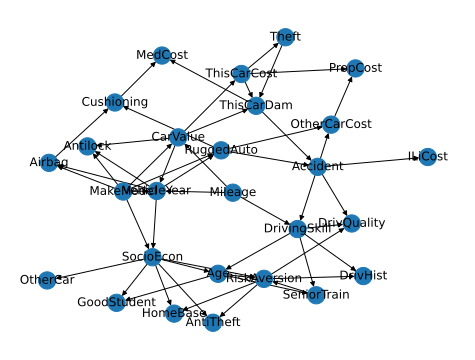

In [41]:
from pgmpy.models import BayesianModel
import networkx as nx
import pylab as plt
pos = nx.nx_agraph.graphviz_layout(example)
nx.draw(example, pos=pos, with_labels=True)
plt.show()

In [ ]:
type(example)

In [ ]:
bm = pgmpy.models.BayesianModel(example)